# Time Series E2E Mini-Project

# Goal:

- Construct an ML Time Series model that analyzes the patterns in temperature over time.

- The model will then forecast temperature into the future.

- Deliver a report that explains what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in predicting temperature.


# Imports

In [110]:
#standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import math
from math import sqrt
import random

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

#filter out any noisy warning flags
import warnings
warnings.filterwarnings('ignore')

# setting the seed
a = random.seed(123)

# Acquire

In [111]:
# acquire the data by reading in the csv
temp_df = pd.read_csv('GlobalLandTemperaturesByState.csv')
    
temp_df

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


# Prepare

In [112]:
# change the dt column from an object to a datetime
temp_df['dt'] = pd.to_datetime(temp_df['dt'], infer_datetime_format=True)

temp_df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
State                                    object
Country                                  object
dtype: object

In [113]:
# drop the avg. temp. uncertaintainty column. The differences in temps are miniscule.
temp_df = temp_df.drop(columns=['AverageTemperatureUncertainty'])

In [114]:
# add a year, month, and day of the week columns
temp_df['year'] = temp_df['dt'].dt.year
temp_df['month'] = temp_df['dt'].dt.month_name()
temp_df['day_of_week'] = temp_df['dt'].dt.day_name()

# set the index to the datetime
temp_df = temp_df.set_index('dt')
temp_df.head()

,AverageTemperature,State,Country,year,month,day_of_week
dt,,,,,,
1855-05-01,25.544,Acre,Brazil,1855,May,Tuesday
1855-06-01,24.228,Acre,Brazil,1855,June,Friday
1855-07-01,24.371,Acre,Brazil,1855,July,Sunday
1855-08-01,25.427,Acre,Brazil,1855,August,Wednesday
1855-09-01,25.675,Acre,Brazil,1855,September,Saturday


In [115]:
# checking the number of observations and features
temp_df.shape

(645675, 6)

In [116]:
# include only the observations from Acre, Brazil and only the years from 1980-2013.
# the data prior to 1980 has a lot of missing data that might distort the overall data.
temp_df = temp_df.loc[temp_df["State"] == 'Acre']
temp_df = temp_df.loc[temp_df['year'] >= 1980]

temp_df

,AverageTemperature,State,Country,year,month,day_of_week
dt,,,,,,
1980-01-01,26.652,Acre,Brazil,1980,January,Tuesday
1980-02-01,26.495,Acre,Brazil,1980,February,Friday
1980-03-01,26.270,Acre,Brazil,1980,March,Saturday
1980-04-01,26.430,Acre,Brazil,1980,April,Tuesday
1980-05-01,25.802,Acre,Brazil,1980,May,Thursday
...,...,...,...,...,...,...
2013-05-01,26.034,Acre,Brazil,2013,May,Wednesday
2013-06-01,26.033,Acre,Brazil,2013,June,Saturday
2013-07-01,24.807,Acre,Brazil,2013,July,Monday


In [117]:
# 293 null observations dropped, without any avg. temp. these observations are not useful.
temp_df = temp_df.dropna()

In [118]:
# take a look at the new df and see if the null values have been dropped.
temp_df

,AverageTemperature,State,Country,year,month,day_of_week
dt,,,,,,
1980-01-01,26.652,Acre,Brazil,1980,January,Tuesday
1980-02-01,26.495,Acre,Brazil,1980,February,Friday
1980-03-01,26.270,Acre,Brazil,1980,March,Saturday
1980-04-01,26.430,Acre,Brazil,1980,April,Tuesday
1980-05-01,25.802,Acre,Brazil,1980,May,Thursday
...,...,...,...,...,...,...
2013-04-01,26.398,Acre,Brazil,2013,April,Monday
2013-05-01,26.034,Acre,Brazil,2013,May,Wednesday
2013-06-01,26.033,Acre,Brazil,2013,June,Saturday


In [119]:
# convert from celsius to farenheit and check the df
temp_df.AverageTemperature = temp_df.AverageTemperature * 1.8 + 32

temp_df.head()

,AverageTemperature,State,Country,year,month,day_of_week
dt,,,,,,
1980-01-01,79.9736,Acre,Brazil,1980,January,Tuesday
1980-02-01,79.6910,Acre,Brazil,1980,February,Friday
1980-03-01,79.2860,Acre,Brazil,1980,March,Saturday
1980-04-01,79.5740,Acre,Brazil,1980,April,Tuesday
1980-05-01,78.4436,Acre,Brazil,1980,May,Thursday


In [120]:
# resample the data by month and average temp.
df_resampled = temp_df.resample('m')[['AverageTemperature']].mean()

df_resampled.head()

,AverageTemperature
dt,
1980-01-31,79.9736
1980-02-29,79.6910
1980-03-31,79.2860
1980-04-30,79.5740
1980-05-31,78.4436


# Explore

In [121]:
# run a print statement to check the range of dates we are working with.
print('Date Range:', temp_df.index.min(), 'to', temp_df.index.max())
print('Shape:', temp_df.shape)

Date Range: 1980-01-01 00:00:00 to 2013-08-01 00:00:00
Shape: (404, 6)


In [122]:
# split the data into train and val/test
train_len = int(0.6 * len(df_resampled))
val_test_split = int(0.8 * len(df_resampled))

train_len, val_test_split

(242, 323)

In [123]:
# split the data into train, validate, test
train = df_resampled.iloc[:train_len]
val = df_resampled.iloc[train_len:val_test_split]
test = df_resampled.iloc[val_test_split:]

train.shape, val.shape, test.shape

((242, 1), (81, 1), (81, 1))

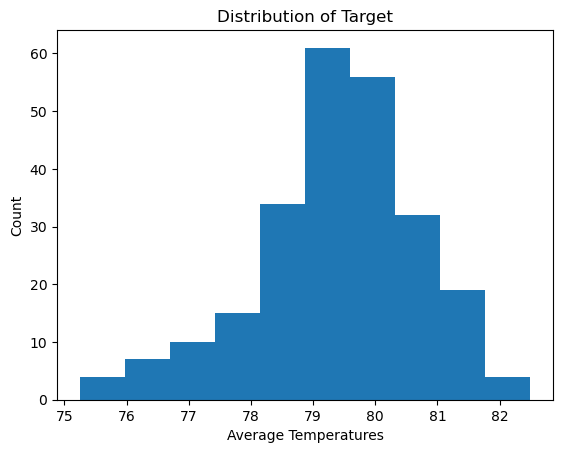

In [124]:
# visualize the distribution of average temperatures.
y = train['AverageTemperature']
y.plot.hist()
plt.xlabel('Average Temperatures')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

In [125]:
months = temp_df['month'].value_counts()

***Takeaways*** 

- Average temperature is normally distributed
- The majority of temperatures are between 78-80 degrees

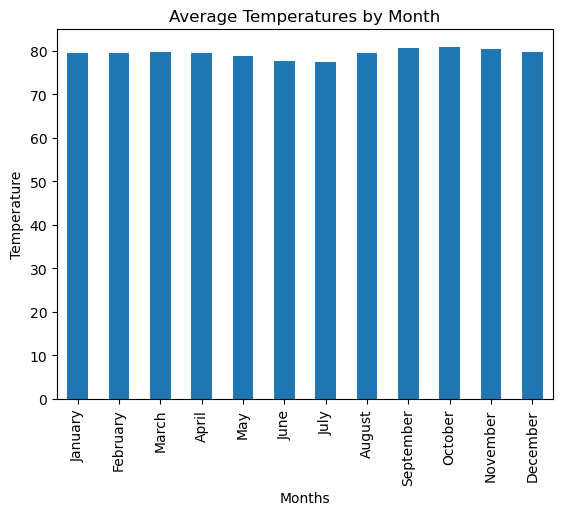

In [128]:
# create categorical months to sort by month vs alphabetical
months_categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
temp_df["month"] = pd.Categorical(temp_df["month"], categories = months_categories)
temp_df.sort_values(by = "month")

# visualize the average temperatures by month
temp_df.groupby('month')['AverageTemperature'].mean().plot.bar()

plt.xlabel('Months')
plt.ylabel('Temperature')
plt.title('Average Temperatures by Month')
plt.show()

***Takeaways**

- Temperatures remained about the same around the high 70s.

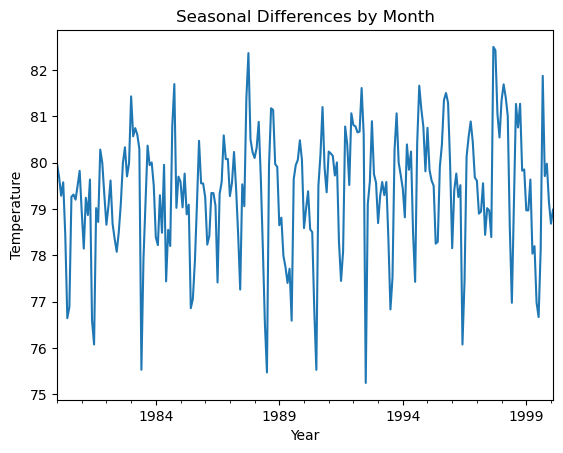

In [129]:
# create a visualization using a .plot to see the seasonal changes.
train['AverageTemperature'].resample('M').mean().plot()
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Seasonal Differences by Month')
plt.show()

***Takeaways***

- Temperatures remained fairly consistent throughout time.
- There appears to be a drop in temperatures about every 3-5 years; however, starting about 1994 the temperature drops appear to be less.

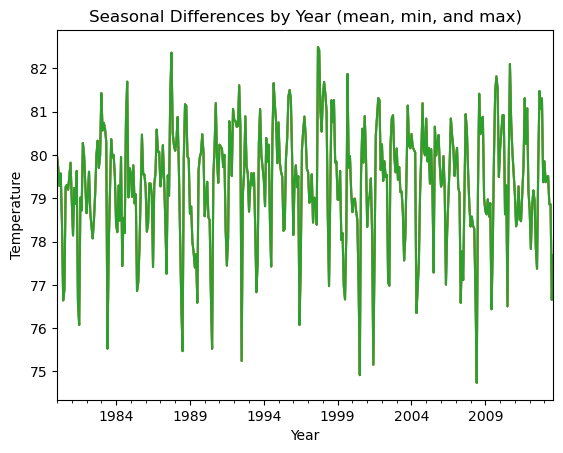

In [130]:
# visualization of the mean, min, and max of the seasonal changes.
temp_df['AverageTemperature'].resample('M').mean().plot()
temp_df['AverageTemperature'].resample('M').min().plot()
temp_df['AverageTemperature'].resample('M').max().plot()
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Seasonal Differences by Year (mean, min, and max)')
plt.show()

***Takeaways***

- Temperatures are so consistent and similar that the mean, min, and max are all almost on top of one another.

In [131]:
# creating a df of shifted data by year
monthly_mean = temp_df.resample('Y').mean()
monthly_mean['shifted'] = monthly_mean['AverageTemperature'].shift(-1)

monthly_mean

,AverageTemperature,year,shifted
dt,,,
1980-12-31,78.965750,1980.0,78.732200
1981-12-31,78.732200,1981.0,79.172450
1982-12-31,79.172450,1982.0,79.668200
1983-12-31,79.668200,1983.0,79.144100
1984-12-31,79.144100,1984.0,78.904100
1985-12-31,78.904100,1985.0,79.225550
1986-12-31,79.225550,1986.0,79.775450
1987-12-31,79.775450,1987.0,79.437650
1988-12-31,79.437650,1988.0,78.756200


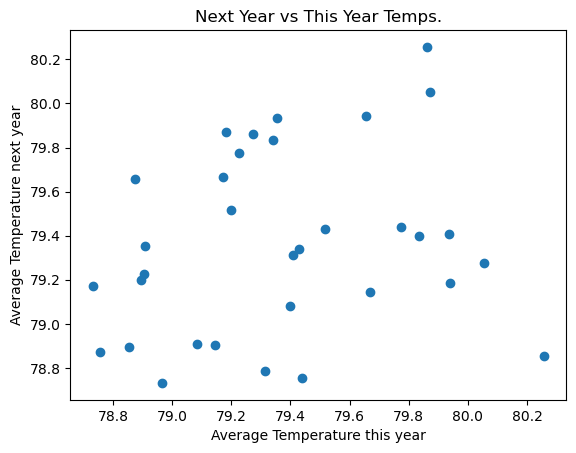

In [132]:
# visualizing the shifted data, comparing current year to next year.
plt.scatter(monthly_mean['AverageTemperature'], monthly_mean['shifted'])
plt.xlabel('Average Temperature this year')
plt.ylabel('Average Temperature next year')
plt.title('Next Year vs This Year Temps.')
plt.show()

***Takeaways***

- The temperatures are so close together and consistent that there is no discernable connection from one year to the next.

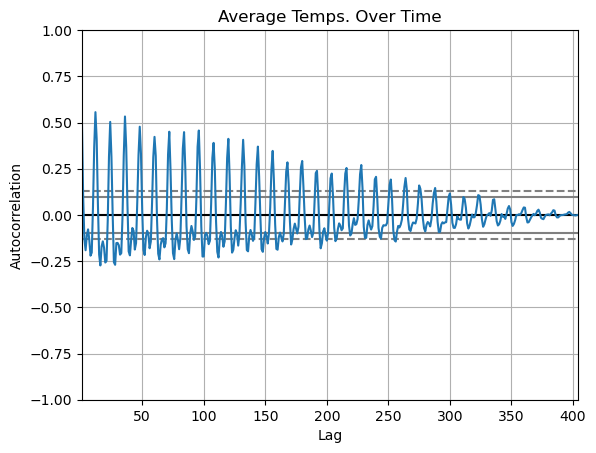

In [133]:
# visualization of the autocorrelation for average temperature.
pd.plotting.autocorrelation_plot(temp_df['AverageTemperature'].resample('M').mean())
plt.title('Average Temps. Over Time')
plt.show()

***Takeaways***

- As indicated by the autocorrelation visualization, the average temperature starts to flatten out and the max temp. gets closer and closer to the min temp.

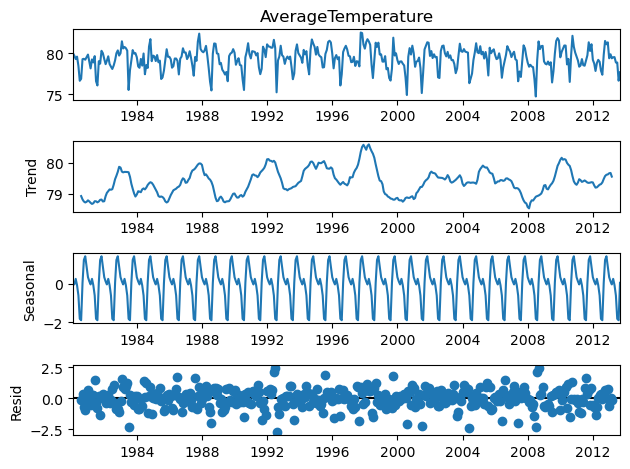

In [134]:
# visualizing the trend, seasonal changes, and residuals.
result = sm.tsa.seasonal_decompose(temp_df['AverageTemperature'].resample('M').mean())

result.plot()
None

***Takeaways***

- Beginning in 1993 the minimum drops in average temperatures significantly decreases.
- The trend in the data indicates that the average temperature in Acre will be very close to one temperature, neither increasing or decreasing signficantly.

# Modeling

In [135]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = sqrt(mean_squared_error(val[target_var], yhat_df[target_var]))
    return rmse

In [136]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(val[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [137]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [138]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last Observed Value

In [139]:
# checking the last observed value
train['AverageTemperature'][-1:][0]

78.9836

In [140]:
# take the last avg temp. of avg temps. and assign to variable
last_temp = train['AverageTemperature'][-1:][0]

In [141]:
# creating a df containing the predictions
yhat_df = pd.DataFrame(
    {'AverageTemperature': last_temp},
    index=val.index)

yhat_df.head()

,AverageTemperature
dt,
2000-03-31,78.9836
2000-04-30,78.9836
2000-05-31,78.9836
2000-06-30,78.9836
2000-07-31,78.9836


AverageTemperature -- RMSE: 1


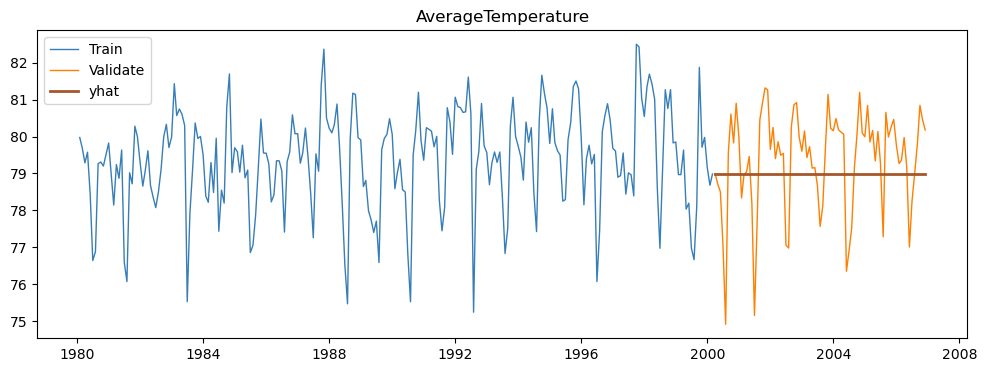

In [142]:
# plotting the actual and predicted values using the plot_and_eval function
for col in train.columns:
    plot_and_eval(col)

In [143]:
# evaluating using MSE and RMSE, and adding evaluation metrics to eval_df.
# and using the append_eval_df function to accomplish this.
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,1.392244


# Simple Average

In [144]:
# compute simple average of average temp. (from train data)
avg_temp = round(train['AverageTemperature'].mean(), 2)
avg_temp

79.38

In [145]:
# making a prediction for the value of avg_temp and stored as the dataframe yhat_df
# for every day of the validate index. 
def make_baseline_predictions(temp_predictions=None):
    yhat_df = pd.DataFrame({'AverageTemperature': [temp_predictions]},
                          index=val.index)
    return yhat_df

In [146]:
# setting yhat_df to the baseline
yhat_df = make_baseline_predictions(avg_temp)

AverageTemperature -- RMSE: 1


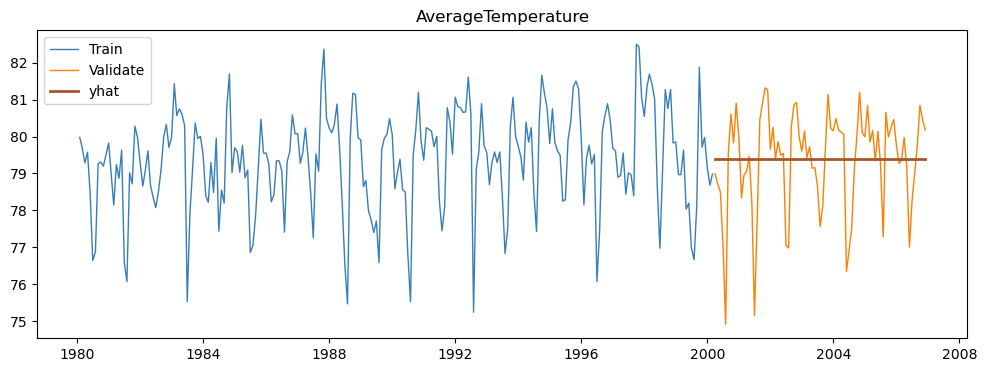

In [147]:
# plotting the yhat_df values against the actual values in validate using the
# plot_and_eval function.
for col in train.columns:
    plot_and_eval(col)

In [148]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df.
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,1.392244
1,simple_average,AverageTemperature,1.333068


# Holt's Linear Model

In [149]:
# create our Holt Object
col = 'AverageTemperature' 
model = Holt(train[col], exponential=False, damped=True)

In [150]:
# fit the Holt object
model = model.fit(optimized=True)

AverageTemperature -- RMSE: 1


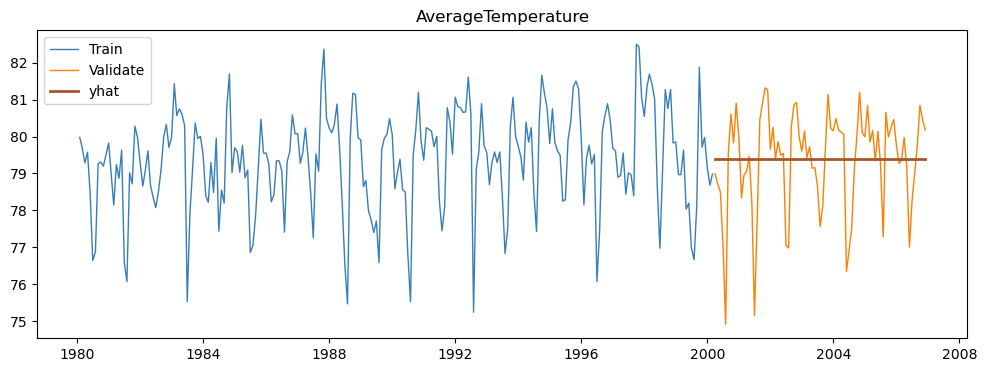

In [151]:
# plotting actual vs predicted values
for col in train.columns:
    plot_and_eval(target_var = col)

In [152]:
# adding holts linear model to the eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [153]:
# sorting the eval_df to rate the best performing models
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,simple_average,AverageTemperature,1.333068
2,holts_optimized,AverageTemperature,1.333068
0,last_observed_value,AverageTemperature,1.392244


# Holt's Seasonal Trend

In [154]:
# Models for avg. temp.
hst_temp_fit1 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=30, trend='add', seasonal='add').fit()
hst_temp_fit2 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=30, trend='add', seasonal='mul').fit()
hst_temp_fit3 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=30, trend='add', seasonal='add', damped=True).fit()
hst_temp_fit4 = ExponentialSmoothing(train.AverageTemperature, seasonal_periods=30, trend='add', seasonal='mul', damped=True).fit()

In [155]:
# using the SSE attribute so we can use it to compare performance.  
results_temp=pd.DataFrame({'model':['hst_temp_fit1', 'hst_temp_fit2', 'hst_temp_fit3', 'hst_temp_fit4'],
                              'SSE':[hst_temp_fit1.sse, hst_temp_fit2.sse, hst_temp_fit3.sse, hst_temp_fit4.sse]})
results_temp

,model,SSE
0,hst_temp_fit1,275.983821
1,hst_temp_fit2,277.602730
2,hst_temp_fit3,273.902724
3,hst_temp_fit4,275.491312


In [156]:
# visualizing the performance of the various models and hyperparameters.
results_temp.sort_values(by='SSE')

,model,SSE
2,hst_temp_fit3,273.902724
3,hst_temp_fit4,275.491312
0,hst_temp_fit1,275.983821
1,hst_temp_fit2,277.602730


In [157]:
# creating predictions using the best Holt's Seasonal model
yhat_df = pd.DataFrame({'AverageTemperature': hst_temp_fit3.forecast(val.shape[0])},
                          index=val.index)
yhat_df

,AverageTemperature
dt,
2000-03-31,80.096111
2000-04-30,80.266603
2000-05-31,79.393985
2000-06-30,78.623781
2000-07-31,78.894758
...,...
2006-07-31,78.000182
2006-08-31,78.937988
2006-09-30,79.628893


AverageTemperature -- RMSE: 1


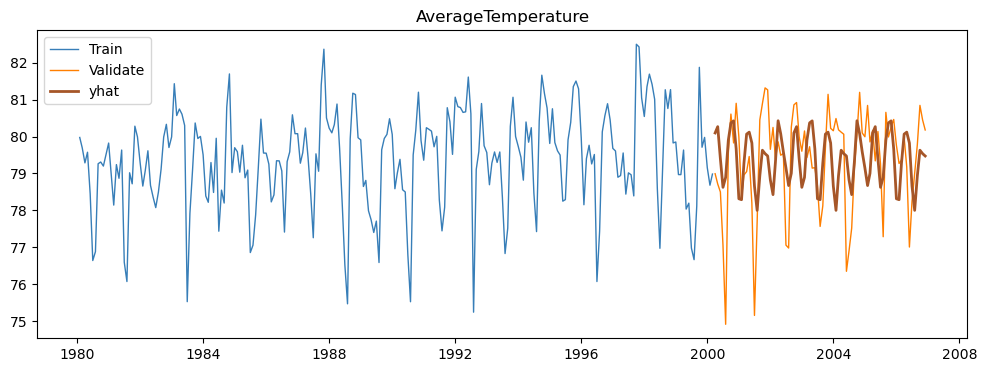

In [158]:
# plotting actual vs predicted values
for col in train.columns:
    plot_and_eval(col)

In [159]:
# taking a looking at the models performance.
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,1.392244
1,simple_average,AverageTemperature,1.333068
2,holts_optimized,AverageTemperature,1.333068


In [160]:
# adding holts seasonal to the eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [161]:
# ranking the models
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
3,holts_seasonal_add_add,AverageTemperature,1.279642
1,simple_average,AverageTemperature,1.333068
2,holts_optimized,AverageTemperature,1.333068
0,last_observed_value,AverageTemperature,1.392244


In [162]:
# find which model did the best
temp_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
eval_df[((eval_df.rmse == temp_total_min_rmse))]

,model_type,target_var,rmse
3,holts_seasonal_add_add,AverageTemperature,1.279642


# Test

In [163]:
# creating predictions for our test dataset
yhat_df = pd.DataFrame({'AverageTemperature': hst_temp_fit3.forecast(val.shape[0] + test.shape[0])})
yhat_df

,AverageTemperature
2000-03-31,80.096111
2000-04-30,80.266603
2000-05-31,79.393985
2000-06-30,78.623781
2000-07-31,78.894758
...,...
2013-04-30,80.423564
2013-05-31,79.662995
2013-06-30,78.314606
2013-07-31,78.289016


In [164]:
# seeing the first date listed in validate
val.head(1)

,AverageTemperature
dt,
2000-03-31,78.9926


In [165]:
# looking at the first date listed in test to see where to slice the data.
test.head(1)

,AverageTemperature
dt,
2006-12-31,79.5164


In [166]:
# the original test set started on 2016-12-31, 
# so we can slice out that portion from the yhat_df.
yhat_df = yhat_df['2006-12-31':]

In [167]:
# creating a function for the final plot that includes test
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(val[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [168]:
# adding the rmse on avg_temp
rmse_temp_total = sqrt(mean_squared_error(test['AverageTemperature'], 
                                       yhat_df['AverageTemperature']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-temp total:  1.2814079604594404


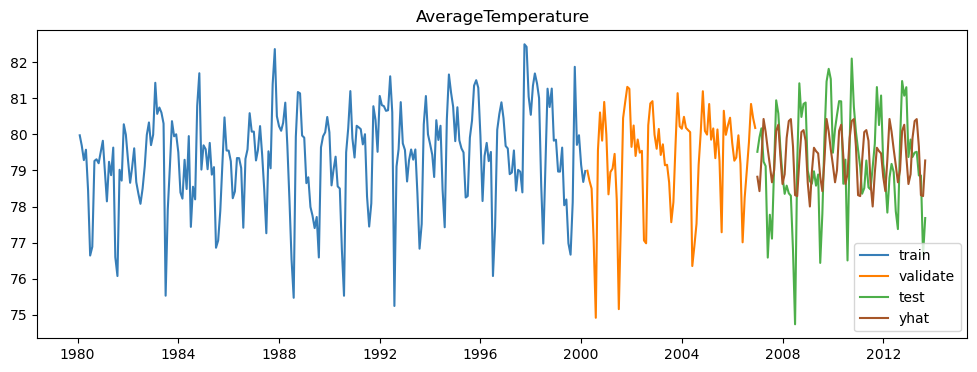

In [169]:
# visualizing the final plot and printing out the rmse data on test.
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-temp total: ', rmse_temp_total)
for col in train.columns:
    final_plot(col)

***Takeaway***

- The RMSE on the final model got slightly worse on the test data. Its possible that while the performance of the model starts high, it degrades the further out it projects.

# Forecasting

In [170]:
# taking a look at the last five dates on our test data.
test.tail()

,AverageTemperature
dt,
2013-04-30,79.5164
2013-05-31,78.8612
2013-06-30,78.8594
2013-07-31,76.6526
2013-08-31,77.6804


In [171]:
# creating the predictions for the forecast
forecast = pd.DataFrame({'AverageTemperature': hst_temp_fit3.forecast(val.shape[0] + test.shape[0] + 365)})
forecast = forecast['2014':'2016']

forecast

,AverageTemperature
2014-01-31,78.000182
2014-02-28,78.937988
2014-03-31,79.628893
2014-04-30,79.535673
2014-05-31,79.471982
2014-06-30,78.825152
2014-07-31,78.426136
2014-08-31,79.307063
2014-09-30,80.426428
2014-10-31,80.075107


In [172]:
# adding a function for the final visualization that includes the forecast.
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(val[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

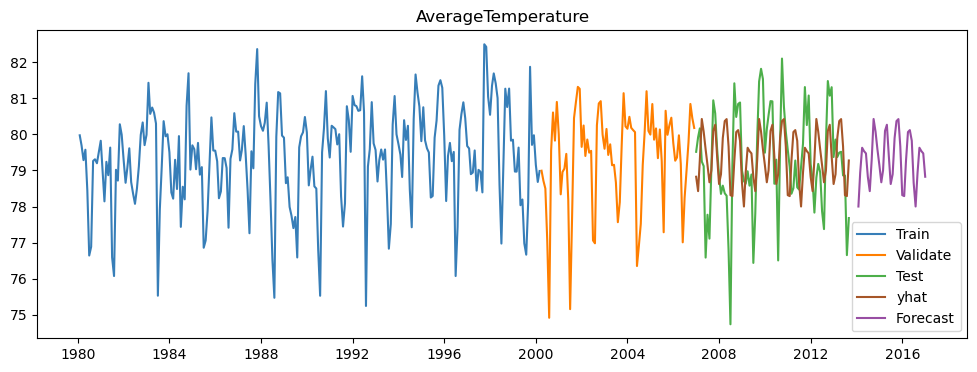

In [173]:
# looking at the train, validate, test, predictions, and forecast results.
for col in train.columns:
    final_plot(col)

***Takeaways***

The forecast follows the trend of the yhat, predicting temperatures at an extremely consistent rate. Using a state within Brazil that has a temperature range from 75-80 degrees does not allow for any significant differences in average temperatures from month to month and year to year. However, it should be noted that after 1993 and about 2009 the average temperatures became closer together from about 77 degrees to about 81 degrees. From this data it can be estimated that the temperatures may continue to become closer together as the years progess.